## First step: Upload a file
Upload the data to database, and read cvs to data.

In [1]:
import pandas as pd
import spacy

In [2]:
from google.colab import files
database = files.upload()

Saving MoodyLyrics_final.csv to MoodyLyrics_final.csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(database['MoodyLyrics_final.csv']))

## Second Step: Get Pretrain nlp.

In [4]:
!python -m spacy download en_core_web_lg

2023-05-18 20:00:29.126227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 568.4 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [5]:
spacy_lang = 'en_core_web_lg'
nlp = spacy.load(spacy_lang)

## Third Step: Preprare the Data and Other preparatory work

In [6]:
dataset = data
emotion_labels = ['happy', 'sad', 'relaxed', 'angry']
mapping = dict(zip(emotion_labels, range(len(emotion_labels)))) # { 'happy' : 0, 'sad': 1, 'relaxed': 2, 'angry': 3 }
dataset['Mood'] = dataset['Mood'].map(mapping)

In [7]:
def remove_stopwords(doc):
    tks = list(filter(lambda tk: not tk.is_stop, doc))
    return spacy.tokens.Doc(nlp.vocab, words=[tk.text for tk in tks])

def doc_preprocess(doc):
    d = remove_stopwords(doc)
    return d

In [8]:
import numpy as np
rows = list()
dataset['Vector'] = np.nan
dataset['Vector_Norm'] = np.nan
for index, row in dataset.iterrows():
    if index < 1000:
        name = row['Title']
        emotion = row['Mood']
        lyric = row['Lyrics_after_stopwords']
        if not pd.isna(lyric):
            doc = nlp(lyric)
            doc = doc_preprocess(doc)
            if len(doc.vector) == 300:
                rows.append((
                    name,
                    lyric,
                    emotion, doc.vector,
                    doc.vector_norm
                ))

In [9]:
# Let us see the data!
dd = pd.DataFrame(rows, columns=['Title','Lyrics_after_stopwords', 'Mood', 'Vector', 'Vector_Norm'])
print(dd)

                         Title  \
0           There Goes My Baby   
1                   On My Mind   
2                Rockstar 101    
3                          Bed   
4            Don't Haffi Dread   
..                         ...   
995             Big Difference   
996  Make Out Fall Out Make Up   
997             Because Of You   
998                 Summertime   
999      Blood Sugar Sex Magik   

                                Lyrics_after_stopwords  Mood  \
0    yeah right usher baby okay yeah man right turn...     2   
1    ahhhhhhhh youre om mind yea verse im thinkin g...     2   
2    told ya told ya told ya baby baby uh uh told y...     2   
3    j holiday oooh oooh ayayay ay ayayay ay ayayay...     2   
4    yeah yeah yeah ragga ragga dont ha fi dread ra...     3   
..                                                 ...   ...   
995  quiet kid coming stay says im lonely says im l...     1   
996  records clothes floor remind night pounding pa...     1   
997  theres son

In [10]:
print(dd.loc[0, 'Lyrics_after_stopwords'])

yeah right usher baby okay yeah man right turn lights goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look bet aint know checking putting heels swear bodys perfect baby work baby yeah wooo love way poking girl feel believe gone twerking end night baby ive waiting day wrap hands waist kiss face wouldnt trade feeling minute ill sit long takes soon come walking way gon hear goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look chills face place girl feel like im movie baby im like oowee baby like waterfalls hair falls waist taste girl need creep cause baby aint ashamed calling girl ive waiting day wrap hands waist kiss face wouldnt trade feeling minute ill sit long takes soon come walking way gon hear goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look girl feel like time time baby loving feels better heart dont need ring promise time away wont change love goes baby oooh girl look dont know good feel

In [11]:
#split the dataset
from sklearn.model_selection import train_test_split
X_vect = dd['Vector'].values.T
X_vect = np.array([np.array(x) for x in X_vect])
X_norm = dd['Vector_Norm'].values
y = dd['Mood'].values

# Assuming you have your feature matrix X and target variable y
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

## Fourth Step: Train Model

### KNN-success

In [ ]:
#parameter tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for k in ks:
    # Build model
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
    # Evaluate accuracy
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print('Accuracy for k=%d: %0.2f (+/- %0.2f)' % (k, scores.mean(), scores.std() * 1.96))

Accuracy for k=1: 0.69 (+/- 0.09)
Accuracy for k=3: 0.68 (+/- 0.13)
Accuracy for k=5: 0.70 (+/- 0.13)
Accuracy for k=7: 0.72 (+/- 0.12)
Accuracy for k=9: 0.70 (+/- 0.10)
Accuracy for k=11: 0.71 (+/- 0.11)
Accuracy for k=13: 0.71 (+/- 0.12)
Accuracy for k=15: 0.70 (+/- 0.13)
Accuracy for k=17: 0.69 (+/- 0.12)
Accuracy for k=19: 0.70 (+/- 0.10)
Accuracy for k=21: 0.71 (+/- 0.08)


In [ ]:
#parameter tuning using grid search
from sklearn.model_selection import GridSearchCV

clf=KNeighborsClassifier()
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7}
Best Score: 0.72375


In [ ]:
#the best model 
clf = KNeighborsClassifier(n_neighbors=7, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
#classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.92      0.84        66
           1       0.70      0.76      0.73        49
           2       0.89      0.52      0.66        48
           3       0.72      0.76      0.74        37

    accuracy                           0.76       200
   macro avg       0.77      0.74      0.74       200
weighted avg       0.77      0.76      0.75       200



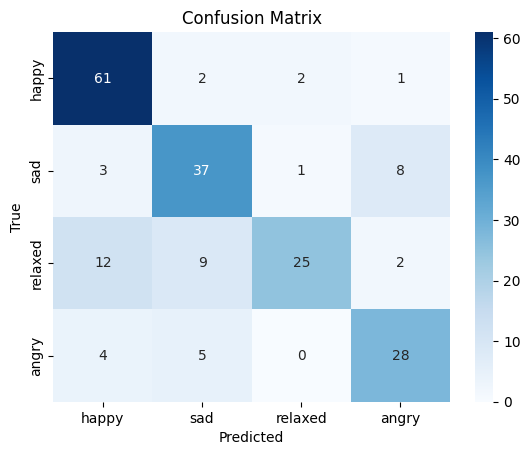

In [ ]:
#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_labels = ['happy', 'sad', 'relaxed', 'angry']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

In [ ]:
# Original Result
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score

# ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

# for k in ks:
#     # Build model
#     clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto', 
#                            metric='euclidean', n_jobs=-1)
#     # Evaluate accuracy
#     scores = cross_val_score(clf, X_vect, y, cv=10)
#     print('Accuracy for k=%d: %0.2f (+/- %0.2f)' % (k, scores.mean(), scores.std() * 1.96))

Accuracy for k=1: 0.64 (+/- 0.12)
Accuracy for k=3: 0.64 (+/- 0.10)
Accuracy for k=5: 0.65 (+/- 0.10)
Accuracy for k=7: 0.68 (+/- 0.09)
Accuracy for k=9: 0.67 (+/- 0.09)
Accuracy for k=11: 0.65 (+/- 0.09)
Accuracy for k=13: 0.65 (+/- 0.10)
Accuracy for k=15: 0.65 (+/- 0.09)
Accuracy for k=17: 0.67 (+/- 0.10)
Accuracy for k=19: 0.67 (+/- 0.09)
Accuracy for k=21: 0.67 (+/- 0.10)


In [ ]:
clf = KNeighborsClassifier(n_neighbors=9, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
clf.fit(X_vect, y)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=9)

### Supervised K-Means-failed

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Create the KMeans object
clf = KMeans(random_state=42,n_init=10)

# Define the parameter grid for grid search
param_grid = {
    'n_clusters': [2,3,4,5, 7, 10],  # Number of clusters to consider
    'init': ['k-means++', 'random'],  # Method for initialization
    'max_iter': [100, 200, 300],  # Maximum number of iterations
}

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=10,scoring='accuracy')

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train,y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer, accuracy_score

# Create the KMeans object
clf = KMeans(n_clusters=4,random_state=42,n_init=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
#classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.23      0.18      0.20        49
           2       0.37      0.75      0.49        48
           3       0.00      0.00      0.00        37

    accuracy                           0.23       200
   macro avg       0.15      0.23      0.17       200
weighted avg       0.14      0.23      0.17       200



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.76875


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
#classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88        66
           1       0.84      0.78      0.81        49
           2       0.76      0.71      0.73        48
           3       0.78      0.84      0.81        37

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



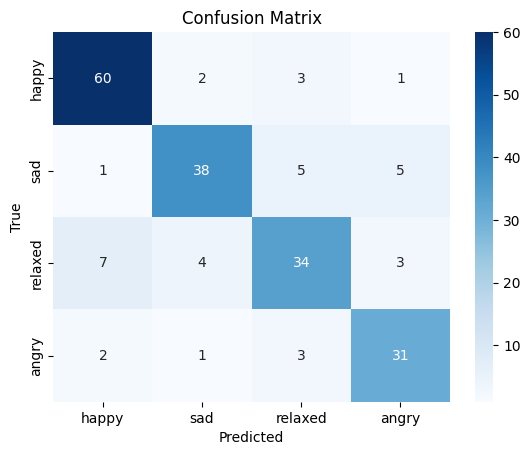

In [ ]:
#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_labels = ['happy', 'sad', 'relaxed', 'angry']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.81 (+/- 0.07)


In [ ]:
from sklearn.metrics import classification_report
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        66
           1       0.81      0.80      0.80        49
           2       0.83      0.71      0.76        48
           3       0.79      0.89      0.84        37

    accuracy                           0.83       200
   macro avg       0.82      0.83      0.82       200
weighted avg       0.83      0.83      0.83       200



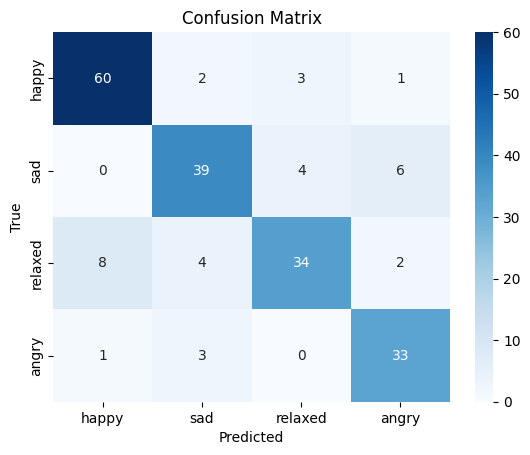

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_labels = ['happy', 'sad', 'relaxed', 'angry']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

### ANN

In [12]:
#1 Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.2, random_state = 0)

In [13]:
# y_nn should be a vector (len(X_vect),4), with a 1 in the right class
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_nn = np_utils.to_categorical(encoded_Y)

In [14]:
#2 Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# we need to scale because we don't want one feature to predomine the others
# Standardize features by removing the mean and scaling to unit variance
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
#1 Importing the Keras libraries and packages
import keras
# Sequential module is required to initialize our ANN
from keras.models import Sequential
# Dense module is required to create the layers
from keras.layers import Dense, Dropout
    
def build_ann(optimizer='adam', input_size=300):
    classifier = Sequential()
    #2 Adding first hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))

    # Adding second hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    classifier.add(Dropout(0.5))

    # Adding output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))

    #3 Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [16]:
classifier = build_ann('adam')
classifier.fit(X_train, y_nn, batch_size = 64, epochs = 50)

#1 Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred1 = np.argmax(y_pred,axis=1)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
y_nn_pred = np_utils.to_categorical(encoded_Y)

Epoch 1/50
13/13 [==============================] - 2s 7ms/step - loss: 1.4066 - accuracy: 0.2375
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 1.3514 - accuracy: 0.3462
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 1.3127 - accuracy: 0.3600
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 1.2851 - accuracy: 0.4238
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 1.2183 - accuracy: 0.4925
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 1.1547 - accuracy: 0.5512
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 1.0934 - accuracy: 0.5725
Epoch 8/50
13/13 [==============================] - 0s 5ms/step - loss: 1.0335 - accuracy: 0.5537
Epoch 9/50
13/13 [==============================] - 0s 5ms/step - loss: 0.9604 - accuracy: 0.6413
Epoch 10/50
13/13 [==============================] - 0s 6ms/step - loss: 0.9103 - accuracy: 0.6612
Epoch 11/50
13/13 [

In [37]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

keras_classifier = KerasClassifier(build_fn=build_ann)
parameters = {'batch_size': [128],
              'epochs': [50],
              'optimizer': ['adam']}
grid_search = GridSearchCV(estimator = keras_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
best_classifier = grid_search.best_estimator_
print('Accuracy: %0.2f' % (best_accuracy*100))

<ipython-input-37-7f986f515d23>:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=build_ann)


Epoch 1/50
6/6 [==============================] - 5s 11ms/step - loss: 1.3967 - accuracy: 0.2722
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 1.3737 - accuracy: 0.3028
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 1.3709 - accuracy: 0.3278
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 1.3584 - accuracy: 0.3347
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 1.3533 - accuracy: 0.3333
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 1.3259 - accuracy: 0.3778
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.3203 - accuracy: 0.4111
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 1.2975 - accuracy: 0.4667
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.2739 - accuracy: 0.4667
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.2472 - accuracy: 0.4958
Epoch 11/50
6/6 [===============

3/3 [==============================] - 0s 6ms/step
Epoch 1/50
6/6 [==============================] - 1s 6ms/step - loss: 1.4047 - accuracy: 0.2986
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 1.3751 - accuracy: 0.3069
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.3669 - accuracy: 0.3111
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 1.3594 - accuracy: 0.3167
Epoch 5/50
6/6 [==============================] - 0s 5ms/step - loss: 1.3454 - accuracy: 0.3542
Epoch 6/50
6/6 [==============================] - 0s 5ms/step - loss: 1.3224 - accuracy: 0.3944
Epoch 7/50
6/6 [==============================] - 0s 4ms/step - loss: 1.3131 - accuracy: 0.4083
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.2917 - accuracy: 0.4181
Epoch 9/50
6/6 [==============================] - 0s 5ms/step - loss: 1.2621 - accuracy: 0.4528
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.2347 - accur

3/3 [==============================] - 0s 4ms/step
Epoch 1/50
6/6 [==============================] - 1s 4ms/step - loss: 1.3835 - accuracy: 0.3028
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.3748 - accuracy: 0.2986
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.3574 - accuracy: 0.3319
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 1.3518 - accuracy: 0.3375
Epoch 5/50
6/6 [==============================] - 0s 5ms/step - loss: 1.3337 - accuracy: 0.3653
Epoch 6/50
6/6 [==============================] - 0s 5ms/step - loss: 1.3220 - accuracy: 0.3875
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 1.2971 - accuracy: 0.4194
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.2785 - accuracy: 0.4389
Epoch 9/50
6/6 [==============================] - 0s 5ms/step - loss: 1.2451 - accuracy: 0.4861
Epoch 10/50
6/6 [==============================] - 0s 5ms/step - loss: 1.2266 - accur

In [19]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred1)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        65
           1       0.85      0.87      0.86        54
           2       0.92      0.79      0.85        43
           3       0.81      0.89      0.85        38

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



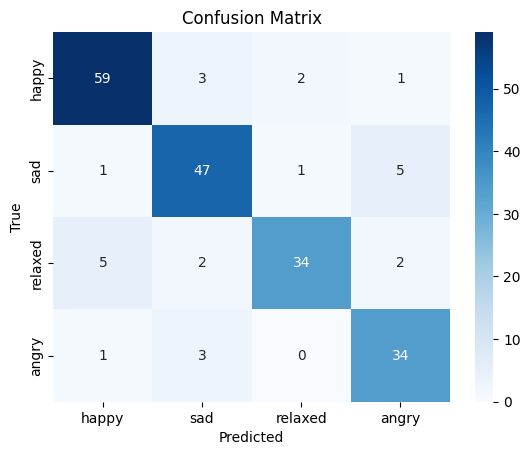

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred1)
class_labels = ['happy', 'sad', 'relaxed', 'angry']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

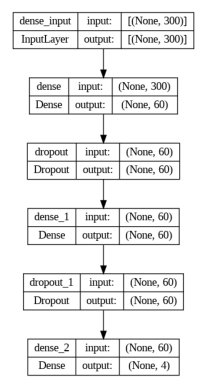

In [22]:
# Plot the model architecture
keras.utils.plot_model(classifier, to_file='ann_structure.png', show_shapes=True)

# Display the image of the model architecture
img = plt.imread('ann_structure.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### SVM

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

In [28]:
# Hyperparameter optimization with GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 200, 300], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 200, 300],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

In [29]:
# Print best parameters
print(grid.best_params_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [30]:
# Predict using the best model
y_pred = grid.predict(X_test)

In [33]:
# Print accuracy
print('Accuracy:', round(accuracy_score(y_test, y_pred), 2))

Accuracy: 0.92


In [34]:
"""
This function computes and plots the confusion matrix.
"""
def plot_confusion_matrix(y_true, y_pred, title, labels, filename):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    df_cnf_matrix = pd.DataFrame(data=cnf_matrix)
    plt.figure(figsize = (8,6))
    #plt.title(title,fontsize=20)
    ax = sns.heatmap(df_cnf_matrix, annot=True, cmap='Blues',fmt='g',square=True,linewidths=.7, cbar_kws={"shrink": .5}, annot_kws={"size": 20})
    ax.set_xticklabels(labels,fontsize=20,  rotation=90)
    b = ax.set_yticklabels(labels,fontsize=20, rotation=360)
    plt.savefig(filename)

Accuracy: 0.84
F1 score: 0.84
Precision: 0.84
Recall: 0.84


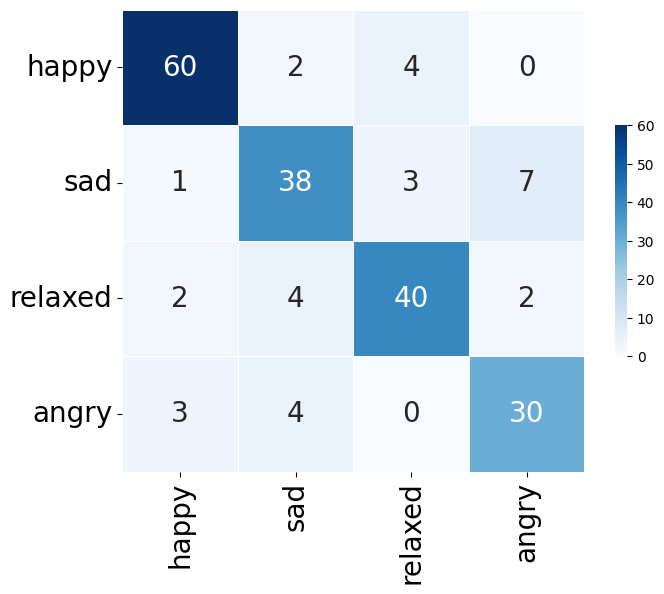

In [35]:
# Fit the model and predict
clf = SVC(C=220, kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calculate and print the metrics
print('Accuracy:', round(accuracy_score(y_test, y_pred), 2))
print('F1 score:', round(f1_score(y_test, y_pred, average='weighted'), 2))
print('Precision:', round(precision_score(y_test, y_pred, average='weighted'), 2))
print('Recall:', round(recall_score(y_test, y_pred, average='weighted'), 2))

filename = 'MODEL_SVM.png'
plot_confusion_matrix(y_test, y_pred, 'SVM - confusion matrix', emotion_labels, filename)

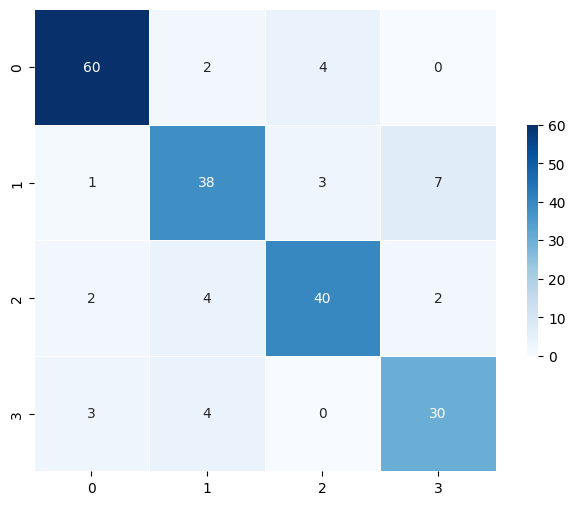

In [36]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g', square=True, linewidths=.7, cbar_kws={"shrink": .5})
plt.show()